# Predicting Stock Movement with Random Forest

## 1. Motivation: Random Forest model allows us to address two inadequacies
* Ensemble method (bagging) that seeks to reduce variance
* Easy addition of features/predictors for learning

References (literature and definition): 
* https://arxiv.org/pdf/1605.00003.pdf
* https://www.investopedia.com/terms
References (where our codes are adapted from):
* https://github.com/LuckysonKhaidem/StockMarketPedicition
* https://github.com/areed1192/sigma_coding_youtube/tree/master/python/python-data-science/machine-learning/random-forest

### 1.1 SIX indicators relevant to triggering buy/sell decisions ###
1. Relative Strength Index, $RSI$
2. Stochastic Oscillator, $K$
3. Williams, %$R$
4. Moving Average Convergence Divergnece, MACD
5. Price Rate of Change, $PROC_{t}$
6. On Balance Volume, OBV
<br>

#### 1.1.1 Relative Strength Index, $RSI$:

$RSI = 100 - \frac{100}{1+RS}$

* A momentum indicator that determines whether the stock is **overbought or oversold**. 
* A stock is said to be overbought when the demand unjustifiably pushes the price upwards. This condition is generally interpreted as a **sign that the stock is overvalued, and the price is likely to go down.** 
* A stock is said to be oversold when the price goes down sharply to a level below its true value, and can be due to panic selling. 

**Implication**
* $RSI$ ranges from 0 to 100 
* $RSI > 70$, stock likely overbought/overvalued, price likely to fall
* $RSI < 30$, stock likely oversold/undervalued, price likely to rise
<br>
<br>

#### 1.1.2 Stochastic Oscillator, $K$:

$K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}$

where, <br>
$C = \text{Current Closing Price}$<br>
$L_{14} = \text{Lowest Low over the past 14 days}$ <br>
$H_{14} = \text{Highest High over the past 14 days}$ 

* Stochastic Oscillator follows the speed or the momentum of the price, and momentum changes before the price changes. 
* It measures the level of the closing price relative to the low-high range over a period of time.

**Implication**
* $K$ ranges from 0 to 100 
* $K > 80$, stock likely overbought/overvalued, price likely to fall
* $K < 80$, stock likely oversold/undervalued, price likely to rise
<br>
<br>

#### 1.1.3 Williams, %$R$:

$R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100$

where, 
$C, L_{14}, H_{14}$ are per definition for $K$

* The Williams $%R$ and the Stochastic Oscillator $K$ end up being almost the exact same indicator. 
* The only difference between the two is how the indicators are scaled, and is included in our model to moderate effects of scaling. 


**Implication**
* $%R$ ranges from -100 to 0 
* $%R > -20$, stock likely overbought/overvalued, price likely to fall
* $%R < -80$, stock likely oversold/undervalued, price likely to rise
<br>
<br>

#### 1.1.4 Moving Average Convergence Divergnece, MACD:

$MACD = EMA_{12}(C) - EMA_{26}(C)$<br>

and<br>

$SignalLine = EMA_{9}(MACD)$


where, <br>
$MACD = \text{Moving Average Convergence Divergence}$<br>
$C = \text{Closing Price}$<br>
$EMA_{n} = \text{n day Exponential Moving Average}$

**Implication**
* EMA is the Exponential Moving Average 
* $MACD > SingalLine$, signal to sell 
* $MACD < SingalLine$, signal to buy
<br>
<br>

#### 1.1.5 Price Rate of Change, $PROC_{t}$:

$PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}$<br>

where, <br>
$PROC_{t} = \text{Price Rate of Change at time t}$<br>
$C_{t} = \text{Closing price at time t}$

**Implication**
* It measures the most recent change in price with respect to the price in n days ago, and is also a **momentum or verlocity indicator**
* here, we let the model learn the importance/weight of this indicator, without any pre-defined threshold
<br>
<br>

#### 6. On Balance Volume, OBV:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\end{equation}
$
<br>

where,<br>
$
\begin{equation}
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$

* On-balance volume (OBV) is a technical indicator of momentum, using volume changes to make price predictions.
* OBV shows crowd sentiment that can predict a bullish or bearish outcome.
<br>
<br>

## 2. Data preparation

### 2.1 Importing libraries and loading data

In [1]:
## Import libraries
import os
import sys
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

# load data
data = pd.read_csv("data_rfc_sgx_2022M10.csv", header = [0,1,2])

def get_prices(symbol,data):
    print(symbol)
    headers = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    prices = [data.loc[:,(header,symbol)].copy().reset_index(drop=True) for header in headers]
    dates = data.loc[:,("Unnamed: 0_level_0","Unnamed: 0_level_1","Date")].reset_index(drop = True)
    combined_lst = [dates] + prices
    combined_df = pd.concat(combined_lst, axis = 1)
    combined_df.columns = ["date"] + [header.lower() for header in headers]
    combined_df = combined_df.interpolate()
#     assert(not combined_df.isnull().values.any())
    combined_df.loc[:,"symbol"] = symbol
    return combined_df

def get_multiple(symbols, data):
    multiple_stock_lst = [get_prices(symbol, data) for symbol in symbols]
    multiple_stock_df = pd.concat(multiple_stock_lst).reset_index(drop = True)
    return multiple_stock_df

symbols = ["D05.SI","S58.SI","BS6.SI","U11.SI","Z74.SI","O39.SI","U96.SI","C07.SI","S51.SI","C09.SI"]
price_data = get_multiple(symbols, data)

D05.SI
S58.SI
BS6.SI
U11.SI
Z74.SI
O39.SI
U96.SI
C07.SI
S51.SI
C09.SI


### 2.2 Preprocessing input attributes, for subsequent generation of input features

* call the `sort_values` method and specify the columns you wish to sort by using the `by` argument. 
    * The first sort is by the `symbol` column, 
    * and the second sort is by the `datetime` column.

* calculate the change in price from one period to the next using `diff()` method. 
    * Grab the `close` column and call the `diff()` method. 
    * The `diff()` method will calculate the difference from one row to the next.

In [2]:
# sort the values by symbol and then date
price_data.sort_values(by = ['symbol','date'], inplace = True)

# calculate the change in price
price_data['change_in_price'] = price_data['adj close'].diff()

### 2.3 Data Preprocessing: Ticker Symbol

* Need to handle rows where ticker symbols change, as it's using the price from a different ticker. So, we need to have the first row of each ticker symbol be `Nan` for the `change_in_price` column. 
    * Step 1: Identify the rows where the ticker symbol changes. If we use the `shift()` method and shift every row down by one, the rows where unshifted column DOES NOT EQUAL the shifted column is where the ticker changed. We will store these values in a variable called `mask`.
    * Step 2: Change those rows to `NaN` values. We can use the `numpy.where()` method to test our series. The test is simple, wherever the `mask` variable equals `True`, in other words, wherever the ticker symbol is different, set the `change_in_price` column to `np.nan`.

* Filter those `NaN` values. there should be 10, corresponding to 10 stocks in our portfolio

In [3]:
# identify rows where the symbol changes
mask = price_data['symbol'] != price_data['symbol'].shift(1)

# For those rows, let's make the value null
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

# print the rows that have a null value, should only be 10, corresponding to 10 stocks in our portfolio
price_data[price_data.isna().any(axis = 1)]

,date,adj close,close,high,low,open,volume,symbol,change_in_price
424,2022-01-03 00:00:00,1.275824,1.350000,1.350000,1.340000,1.340000,2757300.0,BS6.SI,NaN
1484,2022-01-03 00:00:00,20.530001,20.530001,20.639999,20.440001,20.620001,72500.0,C07.SI,NaN
1908,2022-01-03 00:00:00,6.775853,6.880000,6.890000,6.830000,6.830000,796900.0,C09.SI,NaN
0,2022-01-03 00:00:00,31.749357,32.790001,32.830002,32.720001,32.799999,1610600.0,D05.SI,NaN
1060,2022-01-03 00:00:00,10.891167,11.400000,11.440000,11.370000,11.440000,2115000.0,O39.SI,NaN
1696,2022-01-03 00:00:00,0.082000,0.082000,0.083000,0.081000,0.082000,24574500.0,S51.SI,NaN
212,2022-01-03 00:00:00,3.890000,3.890000,3.920000,3.890000,3.890000,551600.0,S58.SI,NaN
636,2022-01-03 00:00:00,25.831663,26.930000,27.030001,26.889999,27.000000,1047200.0,U11.SI,NaN
1272,2022-01-03 00:00:00,2.010000,2.010000,2.020000,2.000000,2.000000,1190600.0,U96.SI,NaN
848,2022-01-03 00:00:00,2.287475,2.330000,2.340000,2.320000,2.330000,11174600.0,Z74.SI,NaN


### 2.4 Generating input features (ie trading indicators)

#### 2.4.1 Calculating Relative Strength Index (RSI); indicator 1/6

**Recap RSI Formula**

$RSI = 100 - \frac{100}{1+RS}$ 

**Coding approach**

1. Copy the desired columns and store them in new variables.
2. Group the columns by the `symbol`, select the column we wish to perform the transformation on and use the `transform` method along with a lambda function to calculate the indicator.
3. Store the values in the main data frame.

In [4]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), 
# meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# # Display the head.
# price_data.head()

#### 2.4.2 Calculating Stochastic Oscillator, $K$; indicator 2/6

**Recall Formula:**

$K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}$

where, <br>
$C = \text{Current Closing Price}$<br>
$L_{14} = \text{Lowest Low over the past 14 days}$ <br>
$H_{14} = \text{Highest High over the past 14 days}$ 

**Coding approach** is similar; with differences being the columns we are copying and the lambda function we are applying. 
* For the RSI, we applied an EMA function, but for the Stochastic Oscillator, we use the rolling function.
* Here, we specify our window, which in this case is 14 periods, and then specify measurement we want to apply to each window. After we obtained the max and min values, we pass it through our formula and apply the results to the main data frame.

In [5]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# # Display the head.
# price_data.head()

#### 2.4.3 Calculating Williams %$R$; indicator 3/6

**Definition From Paper:**

Williams %R ranges from -100 to 0. When its value is above -20, it indicates a sell signal and when its value is below -80, it indicates a buy signal.


**Recap %$R$ Formula:**

$R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100$

where, 
$C, L_{14}, H_{14}$ are per definition for $K$

**Code approach** is identical to the that of Stochastic Oscillator.

In [6]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','low']].copy(), price_data[['symbol','high']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['high'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# # Display the head.
# price_data.head()

#### 2.4.4 Calculating Moving Average Convergence Divergnece (MACD); indicator 4/6

**Recap formula:**<br>

$MACD = EMA_{12}(C) - EMA_{26}(C)$<br>

and<br>

$SignalLine = EMA_{9}(MACD)$


where, <br>
$MACD = \text{Moving Average Convergence Divergence}$<br>
$C = \text{Closing Price}$<br>
$EMA_{n} = \text{n day Exponential Moving Average}$

**Coding approach**

* We require the `close` column for us to apply the `transform` method along with the specified Lambda function. 
* Deriving Exponential Moving Average in `pandas` is straightforward. First, call the `ewm` (exponential moving weight) function and then specify the `span` , ie the number of periods to look back (26 and 12, as indicated in the reference) 
* we take the difference between EMA_12 & EMA_26 to get our MACD. 
* Now that we have our MACD, we need to calculate the EMA of the MACD, so we take our MACD series and apply the same `ewm` function too, but in this case, we specify a `span` of 9. 
* Finally, we add both the MACD and MACD_EMA to the main data frame.

In [7]:
# Calculate the MACD
ema_26 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('symbol')['close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# # Print the head.
# price_data.head()

#### 2.4.5 Calculating Price Rate Of Change; indicator 5/6

**Recap formula:**

$PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}$<br>

where, <br>
$PROC_{t} = \text{Price Rate of Change at time t}$<br>
$C_{t} = \text{Closing price at time t}$


**Coding approach** leverages built-in pandas functions

* Use the `pct_change` function and apply it to our all too familiar symbol groups.
* Include an argument `periods` which specifies how far we need to look back when calculating the rate of change; `n` = 9 seemed to be the standard window.

In [8]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_data['Price_Rate_Of_Change'] = price_data.groupby('symbol')['close'].\
                                     transform(lambda x: x.pct_change(periods = n))

# # Print the first 30 rows to check
# price_data.head(30)

#### Calculating On Balance Volume (OBV); indicator 6/6

**Recap formula:**

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\end{equation}
$
<br>

where,<br>
$
\begin{equation}
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$

**Coding approach**

* Employ the `apply` method to execute a custom function to calculate the `On Balance Volume`. 
* This function calculates the `diff` for the closing price and uses a `for loop` to loop through each row in the `volume` column. If the `change in price`  
    * is greater than 0, we add the volume; 
    * is less than 0, we subtract the volume; 
    * ia equal to 0, we leave it alone.

In [9]:
def obv(group):

    # Grab the volume and close column.
    volume = group['volume']
    change = group['close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    # NOte: need to make sure this a pandas.series
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = price_data.groupby('symbol').apply(obv)

# add to the data frame, but drop the old index, before adding it.
# price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)
price_data['On Balance Volume'] = obv_groups.to_numpy().reshape(-1,1)

# # display the data frame.
# price_data.head()

## 3 Constructing the RF model

### 3.1 Creating the Prediction Column

Our goal is to predict whether the next day is either a `down_day` or an `up_day`. As this point, our data frame doesn't have that column; **we will create it before we feed the data into the model.**
* Step 1. Group our data frame by each `symbol`, and select the `close` column as this contains the price we need to determine if the stock closed up or down for any given day. Now, we can use a similar logic we used to calculate the price change. However, in this case, we only need to know if the price is higher or lower compared to the previous day.
* Step 2. Take these groups, use the `transform` method to apply a lambda function. The lambda function will use the `diff()` function to compare the current price to the previouse price. We then wrap the results of that function in the `numpy.sign()` function. That function will return `1.0` for negative values (down days), `1.0` for postive values, and `0.0` for no change (flat days).

In [10]:
# Create a column we wish to predict

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data.groupby('symbol')['close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. 
# To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

# # print the head
# price_data.head()

# OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
# price_data.to_csv('final_metrics.csv')

### 3.2 Removing `NaN` Values

In [11]:
# We need to remove all rows that have an NaN value.
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], 
                                                              price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], 
                                                             price_data.shape[1]))

# # Print the head.
# price_data.head()

Before NaN Drop we have 2120 rows and 21 columns
After NaN Drop we have 1997 rows and 21 columns


### 3.3 Splitting data to train/test

In [12]:
# Separate the dataset into pre 2022-08-01 and between(2022-08-01, 2022-09-30)
price_data.loc[:,"datetime"] = pd.to_datetime(price_data.date)
price_data_copy = price_data.copy()

# 29th July 2022 is a Friday
price_data_eval = price_data_copy.loc[
    price_data.datetime.between( 
        pd.to_datetime("2022-07-29"), 
        pd.to_datetime("2022-09-30")
        )
    ].reset_index(drop = True)

price_data_oct = price_data_copy.loc[
    price_data.datetime.between( 
        pd.to_datetime("2022-09-30"), 
        pd.to_datetime("2022-10-31")
        )
    ].reset_index(drop = True)

price_data = price_data.loc[
    price_data.datetime < pd.to_datetime("2022-08-01")
                                ].reset_index(drop = True)
# # preview data
# price_data_eval.head()

### 3.4 Pediction with RF

In [13]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 73)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, 
                                       oob_score = True, 
                                       criterion = "gini", random_state = 73)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

### 3.5 RF Model Evaluation

#### 3.5.1 Classification Report and Accuracy Score

In [14]:
# Print the Accuracy of our Model.

from sklearn import metrics

acc_score = metrics.accuracy_score(y_test, rand_frst_clf.predict(X_test), 
                     normalize = True) * 100.0

print(f'Correct Prediction: {acc_score:.2f}%')

# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, 
                               target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(decimals=2)
report_df

Correct Prediction: 75.22%


,precision,recall,f1-score,support
Down Day,0.68,0.72,0.70,137.00
Up Day,0.81,0.78,0.79,210.00
accuracy,0.75,0.75,0.75,0.75
macro avg,0.74,0.75,0.74,347.00
weighted avg,0.76,0.75,0.75,347.00


#### 3.5.2 Confusion Matrix

Accuracy: 75.2%
Precision: 80.7%
Recall: 77.6%
Specificity: 71.5%


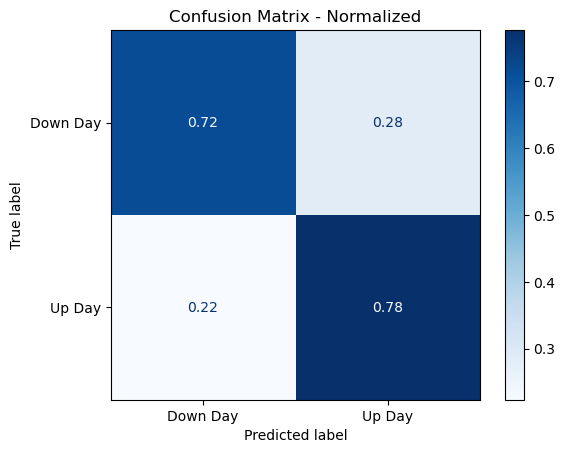

In [15]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_neg = rf_matrix[0][0]
false_neg = rf_matrix[1][0]
true_pos = rf_matrix[1][1]
false_pos = rf_matrix[0][1]

accuracy = (true_neg + true_pos) / (true_neg + true_pos + false_neg + false_pos)
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)
specificity = true_neg / (true_neg + false_pos)

print(f'Accuracy: {100*accuracy:.1f}%')
print(f'Precision: {100*precision:.1f}%')
print(f'Recall: {100*recall:.1f}%')
print(f'Specificity: {100*specificity:.1f}%')

disp = plot_confusion_matrix(rand_frst_clf, 
                             X_test, y_test, 
                             display_labels = ['Down Day', 'Up Day'], 
                             normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

#### 3.5.3 Evaluating and visualizing feature Importance
With Random Forest, we can identify some of our most important features that help explain most of the model.
* Take `rand_frst_clf` and call the `feature_importances_` property. This will return all of our features and their importance measurement. Store the values in a `Pandas.Series` object and sore the values.
* We can see in our model, that the most important feature is `r_percent` and our least important feature is `On Balance Volume`.
* from the visualization, we also saw that we need ALL six features to retain 95% importance

In [16]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, 
                        index=X_Cols.columns).sort_values(ascending=False)

# displaying feature importance
feature_imp

r_percent               0.265024
Price_Rate_Of_Change    0.175577
RSI                     0.155753
k_percent               0.151869
MACD                    0.151332
On Balance Volume       0.100446
dtype: float64

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

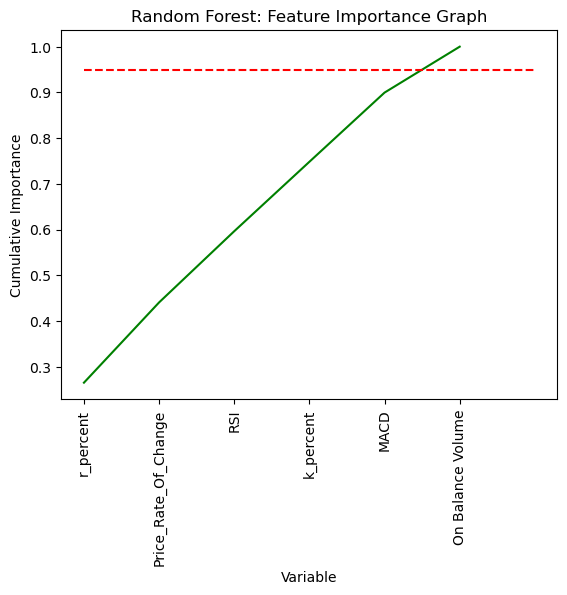

In [17]:
# visualizing feature importance
# store the values in a list to plot.
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

#### 3.5.4 ROC Curve and AUC value
ROC curve shows the trade-off between sensitivity and specificity. 
* When the curve comes closer to the left-hand border and the top border of the ROC space, it indicates that the test is accurate. 
* The closer the curve is to the top and left-hand border, the more accurate the test is. 
* If the curve is close to the 45 degrees diagonal of the ROC space, it means that the test is not accurate. 

AUC ranges in value from 0 to 1. 
* A model whose predictions are 100% wrong has an AUC of 0.0; 
* one whose predictions are 100% correct has an AUC of 1.0

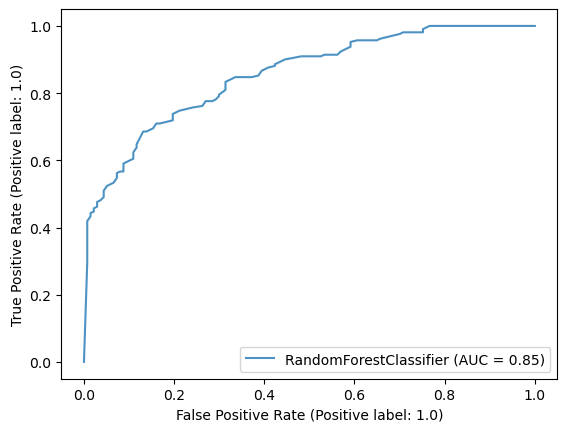

In [18]:
# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()

#### 3.5.5 Out-Of-Bag Error Score comparable to accuracy
The oob is an alternative evalution metric used for RF, and offers several advantages.
* No leakage of data: Since the model is validated on the OOB Sample, which means data hasn’t been used while training the model in any way, so there isn’t any leakage of data and henceforth ensures a better predictive model.
* Less Variance :  More Variance ~ Overfitting due to more training score and less testing score. Since OOB_Score ensures no leakage, so there is no over-fitting of the data and hence least variance.
* Better Predictive Model: OOB_Score helps in the least variance and hence it makes a much better predictive model than a model using other validation techniques.
* Less Computation: It requires less computation as it allows one to test the data as it is being trained.

In [19]:
print(f'Random Forest Out-Of-Bag Error Score: {rand_frst_clf.oob_score_:.3f}')

Random Forest Out-Of-Bag Error Score: 0.734


### 3.6 Model Improvement using Randomized Search

Here, we use `RandomizedSearchCV` method provided by `sklearn.model_selection` module to tune the following hyperparameters:
1. n_estimators - The number of trees in the forest.
2. max_features - The number of features to consider when looking for the best split.
3. max_depth - The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
4. min_samples_split - The minimum number of samples required to split an internal node.
5. min_samples_leaf - The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
6. bootstrap - Whether bootstrap samples are used when building trees. If False, the whole dataset is used to construct each tree.

In [20]:
# Number of trees in random forest
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['sqrt', None, 'log2'] 
    # removed 'auto' which will be deprecated in future updates

# Maximum number of levels in tree; usually as high as possible
# but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 1000, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations 
# which might be highly specific to the particular sample selected for a tree. 
# Too high values can also lead to under-fitting 
# hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [21]:
import time
start_time = time.time()

# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, random_state=73, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

end_time = time.time()
# print duration for training/fitting
print(f'time taken = {(end_time-start_time):.2f}s')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
time taken = 397.01s


display best estimator

In [22]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=440, max_features=None, min_samples_leaf=20,
                       min_samples_split=40, n_estimators=800)


#### 3.6.1 Best estimator from grid search resulted in slight improvement

Correct Prediction: 77.23%


,precision,recall,f1-score,support
Down Day,0.69,0.77,0.73,137.00
Up Day,0.84,0.78,0.80,210.00
accuracy,0.77,0.77,0.77,0.77
macro avg,0.76,0.77,0.77,347.00
weighted avg,0.78,0.77,0.77,347.00


r_percent               0.265024
Price_Rate_Of_Change    0.175577
RSI                     0.155753
k_percent               0.151869
MACD                    0.151332
On Balance Volume       0.100446
dtype: float64

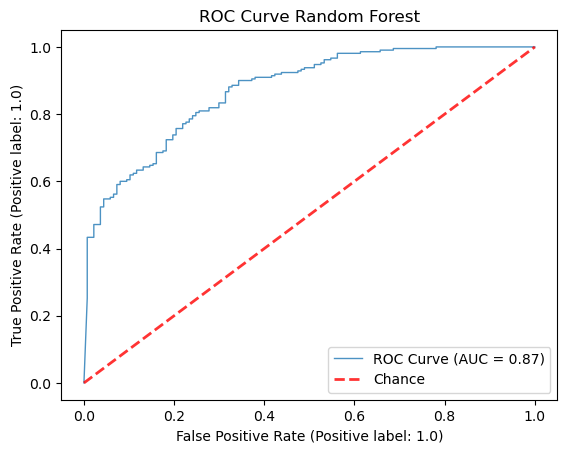

In [23]:
# With the new Random Classifier trained we can proceed to our regular steps, prediction.
y_pred = rf_random.predict(X_test)

from sklearn import metrics

acc_score = metrics.accuracy_score(y_test, y_pred, 
                     normalize = True) * 100.0

print(f'Correct Prediction: {acc_score:.2f}%')

# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, 
                               y_pred = y_pred, 
                               target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(decimals=2)
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)

'''
    ROC CURVE
'''

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rf_random, X_test, y_test, alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()

#### 3.6.2 Save Model for validation and test

the following line of code has been commented so the user does not accidentally overwrite the input file ```rf_random_221031.pkl``` already included in the submission

In [24]:
# import joblib
# # save
# joblib.dump(rf_random, "rf_random_221031.pkl") 

['rf_random_221031.pkl']

## 4. Making prediction using model saved

### 4.1 Validation period, 2022M8-M9

Correct Prediction: 76.28%


,precision,recall,f1-score,support
Down Day,0.73,0.79,0.76,204.00
Up Day,0.80,0.73,0.76,226.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.76,0.76,0.76,430.00
weighted avg,0.77,0.76,0.76,430.00


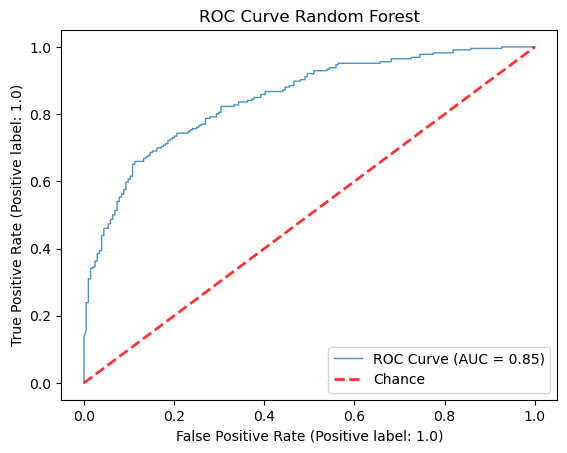

In [25]:
# Load saved model
rf_random = joblib.load("rf_random_221031.pkl") 
clf = rf_random

# Grab our X & Y Columns.
X_Cols_eval = price_data_eval[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols_eval = price_data_eval['Prediction']

# Make predictions
y_pred_eval = rf_random.predict(X_Cols_eval)
y_pred_eval_proba = rf_random.predict_proba(X_Cols_eval)
y_pred_eval_proba.max(axis = 1)

price_data_eval.loc[:,"model_prediction"] = y_pred_eval
price_data_eval.loc[:,"model_proba"] = y_pred_eval_proba.max(axis = 1)

# evaluate model
from sklearn import metrics

y_pred = y_pred_eval
X_test = X_Cols_eval
y_test = Y_Cols_eval

acc_score = metrics.accuracy_score(y_test, y_pred, 
                     normalize = True) * 100.0

print(f'Correct Prediction: {acc_score:.2f}%')

# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, 
                               y_pred = y_pred, 
                               target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(decimals=2)
display(report_df)
print('\n')

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(clf, 
                          X_test, y_test, 
                          alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()

#### 4.1.1 Using prediction to inform buy/sell

We saw that the model performs well during validation period; we will proceed to use model to predict up/down movement of stocks, to imform buy/sell. Here, we assume positions are closed after each trading day

1. If model predicts price increase with probability >= 0.6 (Action = 1) -> Buy
2. If model predicts price increase with probability >= 0.6 (Action = -1) -> Sell
3. If model predicts with probaility < 0.6 (Action = 0) -> Do nothing

Price Change = (P(t) - P(t-1))/P(t-1) <br>
Returns = Action * Price Change <br>
Overall Profit = cumprod(1+Returns)

In [26]:
cumreturns_eval_dct = {}
symbol_eval_dct = {}
returns_eval_dct = {}

for symbol in symbols:
    symbol_eval = price_data_eval.loc[price_data_eval.symbol == symbol,:].copy().reset_index(drop = True)
    symbol_eval.loc[:,"action"] = symbol_eval.model_prediction
    
    # If model predicts with a probability of 0.6, do 
    symbol_eval.loc[symbol_eval.model_proba < 0.6, "action"] = 0
    # If model predicts price increase with probability >= 0.6 (action = 1) -> Buy
    # If model predicts price increase with probability >= 0.6 (action = 1) -> Sell
    # If model predicts with probaility < 0.6 -> Do nothing
    
    current = symbol_eval["adj close"][1:].reset_index(drop = True)
    previous = symbol_eval["adj close"][:-1].reset_index(drop = True)
    change = (current - previous)/previous
    
    symbol_eval.loc[:,"change"] = change
    action = symbol_eval["action"][:-1].reset_index(drop = True)
    returns = action * change
        
    symbol_eval = symbol_eval[1:].reset_index(drop=True)
    symbol_eval.loc[:,"returns"] = returns
    

    cumreturns_eval = (1+returns).cumprod()
    symbol_eval.loc[:,"cumreturns"] = cumreturns_eval
    
    symbol_eval_dct[symbol] = symbol_eval.copy()
    
    returns_eval = float(cumreturns_eval.tail(1))
    returns_eval_dct[symbol] = returns_eval
    
#     print(f"{symbol} returns: {float((1+returns).cumprod().tail(1))}")

return_eval_summary = pd.DataFrame(columns = [])
return_eval_summary.index = symbol_eval_dct[symbols[0]].date

cumreturn_eval_summary = pd.DataFrame(columns = [])
cumreturn_eval_summary.index = symbol_eval_dct[symbols[0]].date

for symbol in symbols:
    symbol_eval = symbol_eval_dct[symbol]
    return_eval_summary.loc[symbol_eval.date.tolist(),symbol] = symbol_eval.returns.to_numpy().reshape(-1,1)
    cumreturn_eval_summary.loc[symbol_eval.date.tolist(),symbol] = symbol_eval.cumreturns.to_numpy().reshape(-1,1)

#### 4.1.2 Calculated returns (>10%) for validation period, 2022M8-M9

In [27]:
# daily returns
return_eval_summary = return_eval_summary.fillna(0)
return_eval_summary.loc[:,"mean"] = return_eval_summary.mean(axis = 1)

# cumulative returns
cumreturn_eval_summary = cumreturn_eval_summary.fillna(method = 'ffill')
cumreturn_eval_summary.loc[:,"mean"] = cumreturn_eval_summary.mean(axis = 1)

# show cumulative returns
cumreturn_eval_summary

,D05.SI,S58.SI,BS6.SI,U11.SI,Z74.SI,O39.SI,U96.SI,C07.SI,S51.SI,C09.SI,mean
date,,,,,,,,,,,
2022-08-01 00:00:00,0.991738,1.002519,1.000000,0.987659,0.988506,1.000000,0.979381,1.050357,1.009174,1.000000,1.000933
2022-08-02 00:00:00,0.991113,0.997481,1.000000,0.993325,0.988506,1.006814,0.979381,1.067857,1.027523,0.993598,1.004560
2022-08-03 00:00:00,1.010492,1.010076,1.010870,0.991534,0.996928,1.021295,0.979381,1.086786,1.045872,0.993598,1.014683
2022-08-04 00:00:00,1.012992,1.012594,0.999761,0.989392,0.993034,1.040034,0.979381,1.103571,1.064220,1.020280,1.021526
2022-08-05 00:00:00,1.026432,1.022670,0.999761,0.989392,1.016218,1.042589,0.979381,1.100000,1.055046,1.029174,1.026066
2022-08-08 00:00:00,1.024244,1.020151,0.999761,0.989756,1.012354,1.045997,0.979381,1.104643,1.082569,1.041880,1.030074
2022-08-09 00:00:00,1.031589,1.022670,0.999761,0.989756,1.018150,1.049830,0.985541,1.112500,1.087156,1.045057,1.034201
2022-08-10 00:00:00,1.038934,1.025189,1.007717,0.989756,1.023946,1.053663,0.991701,1.120357,1.091743,1.048233,1.039124
2022-08-11 00:00:00,1.046123,1.030227,1.034236,0.980277,1.012354,1.061329,1.000940,1.122143,1.091743,1.046963,1.042633


### 4.2 Test period, 2022M10

#### 4.2.1 Using prediction to inform buy/sell

Correct Prediction: 67.34%


,precision,recall,f1-score,support
Down Day,0.61,0.89,0.72,96.00
Up Day,0.82,0.48,0.60,103.00
accuracy,0.67,0.67,0.67,0.67
macro avg,0.71,0.68,0.66,199.00
weighted avg,0.72,0.67,0.66,199.00


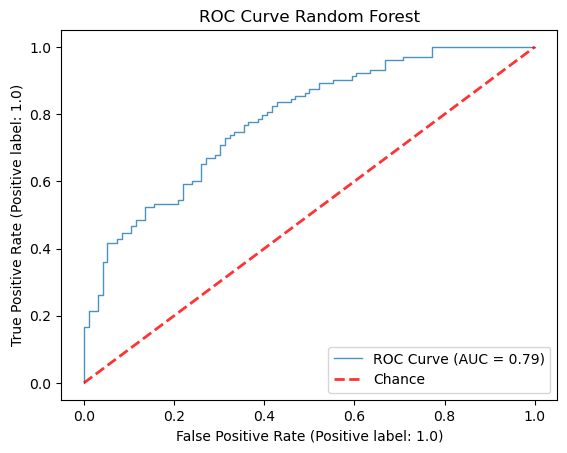

In [28]:
# Load saved model
rf_random = joblib.load("rf_random_221031.pkl") 
clf = rf_random

# Grab our X & Y Columns.
X_Cols_oct = price_data_oct[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols_oct = price_data_oct['Prediction']

# Make predictions
y_pred_oct = rf_random.predict(X_Cols_oct)
y_pred_oct_proba = rf_random.predict_proba(X_Cols_oct)
price_data_oct.loc[:,"model_prediction"] = y_pred_oct

price_data_oct.loc[:,"model_proba"] = y_pred_oct_proba.max(axis = 1)
price_data_oct

# evaluate model
from sklearn import metrics

y_pred = y_pred_oct
X_test = X_Cols_oct
y_test = Y_Cols_oct

acc_score = metrics.accuracy_score(y_test, y_pred, 
                     normalize = True) * 100.0

print(f'Correct Prediction: {acc_score:.2f}%')

# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, 
                               y_pred = y_pred, 
                               target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(decimals=2)
display(report_df)
print('\n')

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(clf, 
                          X_test, y_test, 
                          alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()

#### 4.2.2 Calculated returns (>4%) for test period, 2022M10

In [29]:
cumreturns_oct_dct = {}
symbol_oct_dct = {}
returns_oct_dct = {}

for symbol in symbols:
    symbol_oct = price_data_oct.loc[price_data_oct.symbol == symbol,:].copy().reset_index(drop = True)
    symbol_oct.loc[:,"action"] = symbol_oct.model_prediction
    
    # If model predicts with a probability of 0.6, do 
    symbol_oct.loc[symbol_oct.model_proba < 0.6, "action"] = 0
    # If model predicts price increase with probability >= 0.6 (action = 1) -> Buy
    # If model predicts price increase with probability >= 0.6 (action = 1) -> Sell
    # If model predicts with probaility < 0.6 -> Do nothing
    
    current = symbol_oct["adj close"][1:].reset_index(drop = True)
    previous = symbol_oct["adj close"][:-1].reset_index(drop = True)
    change = (current - previous)/previous
    
    symbol_oct.loc[:,"change"] = change
    action = symbol_oct["action"][:-1].reset_index(drop = True)
    returns = action * change
        
    symbol_oct = symbol_oct[1:].reset_index(drop=True)
    symbol_oct.loc[:,"returns"] = returns
    

    cumreturns_oct = (1+returns).cumprod()
    symbol_oct.loc[:,"cumreturns"] = cumreturns_oct
    
    symbol_oct_dct[symbol] = symbol_oct.copy()
    
    returns_oct = float(cumreturns_oct.tail(1))
    returns_oct_dct[symbol] = returns_oct

# create df for 2022M10 returns    
return_oct_summary = pd.DataFrame(columns = [])
return_oct_summary.index = symbol_oct_dct[symbols[0]].date
cumreturn_oct_summary = pd.DataFrame(columns = [])
cumreturn_oct_summary.index = symbol_oct_dct[symbols[0]].date

for symbol in symbols:
    symbol_oct = symbol_oct_dct[symbol]
    return_oct_summary.loc[symbol_oct.date.tolist(),symbol] = symbol_oct.returns.to_numpy().reshape(-1,1)
    cumreturn_oct_summary.loc[symbol_oct.date.tolist(),symbol] = symbol_oct.cumreturns.to_numpy().reshape(-1,1)

# fill na for missing data
return_oct_summary = return_oct_summary.fillna(0)
return_oct_summary.loc[:,"mean"] = return_oct_summary.mean(axis = 1)
cumreturn_oct_summary = cumreturn_oct_summary.fillna(method = 'ffill')
cumreturn_oct_summary.loc[:,"mean"] = cumreturn_oct_summary.mean(axis = 1)

# display cumulative returns in 2022M10
cumreturn_oct_summary

,D05.SI,S58.SI,BS6.SI,U11.SI,Z74.SI,O39.SI,U96.SI,C07.SI,S51.SI,C09.SI,mean
date,,,,,,,,,,,
2022-10-03 00:00:00,1.007188,1.006645,1.009709,1.003440,0.977444,1.000000,NaN,0.984315,NaN,1.000000,0.998592
2022-10-04 00:00:00,1.000200,1.006645,0.989911,1.000361,0.973684,0.985544,0.996753,0.956208,1.000000,1.000000,0.990931
2022-10-05 00:00:00,0.999001,1.020111,0.989911,0.986972,0.996068,0.990501,1.009656,0.952145,1.045872,1.000000,0.999024
2022-10-06 00:00:00,0.993919,1.006279,0.932800,0.992931,1.007786,0.986370,1.003036,0.956711,1.055046,0.996159,0.993104
2022-10-07 00:00:00,0.990369,1.016376,1.000640,0.994421,1.003787,0.985544,1.003036,0.952914,1.073395,1.002561,1.002304
2022-10-10 00:00:00,0.998654,1.006075,0.975200,0.980640,1.019657,0.985544,1.003036,0.961254,1.082569,0.988476,1.000111
2022-10-11 00:00:00,0.995043,1.026263,1.007438,0.981013,1.015562,0.984706,1.019319,0.994382,1.082569,0.973111,1.007941
2022-10-12 00:00:00,0.990562,1.054284,0.998828,0.978404,1.023687,0.990563,1.036139,1.029875,1.082569,0.973111,1.015802
2022-10-13 00:00:00,1.015134,1.098675,1.024222,0.987302,1.023687,0.999876,1.053524,1.036806,1.082569,0.992242,1.031404


## 5. Supplementary sections

### 5.1 Daily returns 

#### 5.1.1 Training period (2022M1 - 2022M7)

In [30]:
# Load saved model

rf_random = joblib.load("rf_random_221031.pkl") 

# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Make predictions
y_pred = rf_random.predict(X_Cols)

y_pred_proba = rf_random.predict_proba(X_Cols)
y_pred_proba.max(axis = 1)

price_data.loc[:,"model_prediction"] = y_pred
price_data.loc[:,"model_proba"] = y_pred_proba.max(axis = 1)

# print accuracy score

from sklearn import metrics

acc_score = metrics.accuracy_score(Y_Cols, rf_random.predict(X_Cols), 
                     normalize = True) * 100.0

print(f'Correct Prediction: {acc_score:.2f}%')

# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = Y_Cols, 
                               y_pred = y_pred, 
                               target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(decimals=2)
display(report_df)
print('\n')

Correct Prediction: 81.05%


,precision,recall,f1-score,support
Down Day,0.75,0.82,0.79,591.00
Up Day,0.86,0.80,0.83,797.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.81,0.81,0.81,1388.00
weighted avg,0.81,0.81,0.81,1388.00


In [31]:
cumreturns_dct = {}
symbol_dct = {}
returns_dct = {}

for s in symbols:
    symbol = price_data.loc[price_data.symbol == s,:].copy().reset_index(drop = True)
    symbol.loc[:,"action"] = symbol.model_prediction
    
    # If model predicts with a probability of 0.6, do 
    symbol.loc[symbol.model_proba < 0.6, "action"] = 0
    # If model predicts price increase with probability >= 0.6 (action = 1) -> Buy
    # If model predicts price increase with probability >= 0.6 (action = 1) -> Sell
    # If model predicts with probaility < 0.6 -> Do nothing
    
    current = symbol["adj close"][1:].reset_index(drop = True)
    previous = symbol["adj close"][:-1].reset_index(drop = True)
    change = (current - previous)/previous
    
    symbol.loc[:,"change"] = change
    action = symbol["action"][:-1].reset_index(drop = True)
    returns = action * change
        
    symbol = symbol[1:].reset_index(drop=True)
    symbol.loc[:,"returns"] = returns
    

    cumreturns = (1+returns).cumprod()
    symbol.loc[:,"cumreturns"] = cumreturns
    
    symbol_dct[s] = symbol.copy()
    
    returns = float(cumreturns.tail(1))
    returns_dct[s] = returns
    
#     print(f"{symbol} returns: {float((1+returns).cumprod().tail(1))}")

In [32]:
time_range_lst = pd.date_range(start=pd.Timestamp('2022-01-21 00:00:00'), 
                               end=pd.Timestamp('2022-07-31 00:00:00'), freq='1D').to_list()
time_range_lst = [ts.strftime('%Y-%m-%d %X') for ts in time_range_lst ]

return_summary = pd.DataFrame(columns = [])
return_summary.index = time_range_lst

cumreturn_summary = pd.DataFrame(columns = [])
cumreturn_summary.index = time_range_lst

for s in symbols:
    symbol = symbol_dct[s]
    return_summary.loc[symbol.date.tolist(),s] = symbol.returns.to_numpy().reshape(-1,1)
    cumreturn_summary.loc[symbol.date.tolist(),s] = symbol.cumreturns.to_numpy().reshape(-1,1)
    
# fill na for missing data

return_summary = return_summary.fillna(0)
return_summary.loc[:,"mean"] = return_summary.mean(axis = 1)
cumreturn_summary = cumreturn_summary.fillna(method = 'ffill')
cumreturn_summary.loc[:,"mean"] = cumreturn_summary.mean(axis = 1)

# # daily returns for training period
# return_summary

# # cumulative returns for training period
# cumreturn_summary

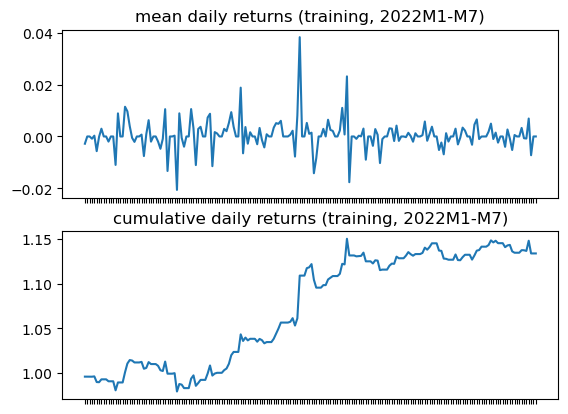

,D05.SI,S58.SI,BS6.SI,U11.SI,Z74.SI,O39.SI,U96.SI,C07.SI,S51.SI,C09.SI,mean
2022-01-21 00:00:00,0.987774,0.987310,0.985075,1.002310,NaN,1.000813,NaN,1.008662,NaN,1.000000,0.995992
2022-01-22 00:00:00,0.987774,0.987310,0.985075,1.002310,NaN,1.000813,NaN,1.008662,NaN,1.000000,0.995992
2022-01-23 00:00:00,0.987774,0.987310,0.985075,1.002310,NaN,1.000813,NaN,1.008662,NaN,1.000000,0.995992
2022-01-24 00:00:00,0.987774,0.987310,0.985075,0.990429,1.004032,1.000000,0.995495,1.017476,NaN,0.995804,0.995933
2022-01-25 00:00:00,0.975032,0.987310,1.029851,0.981188,0.995968,0.987805,0.995495,1.030431,NaN,0.983217,0.996255
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-27 00:00:00,1.212027,1.060097,2.144318,1.232340,0.912376,1.069843,0.821884,1.022348,0.841674,1.050876,1.136778
2022-07-28 00:00:00,1.218537,1.062795,2.224160,1.243784,0.912376,1.079988,0.830242,1.017447,0.841674,1.050876,1.148188
2022-07-29 00:00:00,1.205134,1.049239,2.121506,1.212535,0.915859,1.076299,0.833085,1.017447,0.857407,1.050876,1.133938
2022-07-30 00:00:00,1.205134,1.049239,2.121506,1.212535,0.915859,1.076299,0.833085,1.017447,0.857407,1.050876,1.133938


In [33]:
# Visualize returns for traininig period
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(return_summary['mean'])
ax1.title.set_text('mean daily returns (training, 2022M1-M7)')


ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(cumreturn_summary['mean'])
ax2.title.set_text('cumulative daily returns (training, 2022M1-M7)')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.show()

# display cumulative returns
cumreturn_summary

#### 5.1.2 Daily returns from validation period (2022M8-M9)

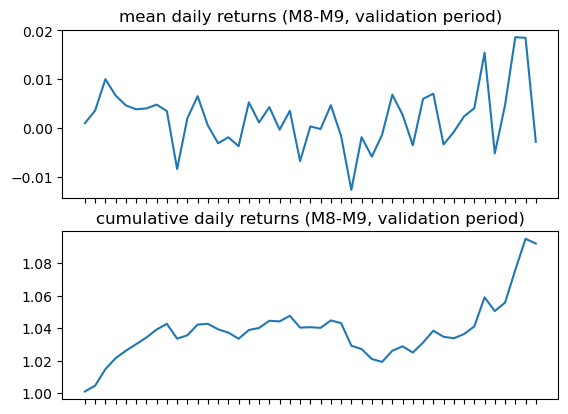

,D05.SI,S58.SI,BS6.SI,U11.SI,Z74.SI,O39.SI,U96.SI,C07.SI,S51.SI,C09.SI,mean
date,,,,,,,,,,,
2022-08-01 00:00:00,0.991738,1.002519,1.000000,0.987659,0.988506,1.000000,0.979381,1.050357,1.009174,1.000000,1.000933
2022-08-02 00:00:00,0.991113,0.997481,1.000000,0.993325,0.988506,1.006814,0.979381,1.067857,1.027523,0.993598,1.004560
2022-08-03 00:00:00,1.010492,1.010076,1.010870,0.991534,0.996928,1.021295,0.979381,1.086786,1.045872,0.993598,1.014683
2022-08-04 00:00:00,1.012992,1.012594,0.999761,0.989392,0.993034,1.040034,0.979381,1.103571,1.064220,1.020280,1.021526
2022-08-05 00:00:00,1.026432,1.022670,0.999761,0.989392,1.016218,1.042589,0.979381,1.100000,1.055046,1.029174,1.026066
2022-08-08 00:00:00,1.024244,1.020151,0.999761,0.989756,1.012354,1.045997,0.979381,1.104643,1.082569,1.041880,1.030074
2022-08-09 00:00:00,1.031589,1.022670,0.999761,0.989756,1.018150,1.049830,0.985541,1.112500,1.087156,1.045057,1.034201
2022-08-10 00:00:00,1.038934,1.025189,1.007717,0.989756,1.023946,1.053663,0.991701,1.120357,1.091743,1.048233,1.039124
2022-08-11 00:00:00,1.046123,1.030227,1.034236,0.980277,1.012354,1.061329,1.000940,1.122143,1.091743,1.046963,1.042633


In [34]:
# Visualize returns for test period

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(return_eval_summary['mean'])
ax1.title.set_text('mean daily returns (M8-M9, validation period)')

ax2 = fig.add_subplot(2,1,2, sharex=ax1)
ax2.plot(cumreturn_eval_summary['mean'])
ax2.title.set_text('cumulative daily returns (M8-M9, validation period)')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.show()

# display cumulative returns
cumreturn_eval_summary

#### 5.1.3 Daily returns from test period (2022M10)

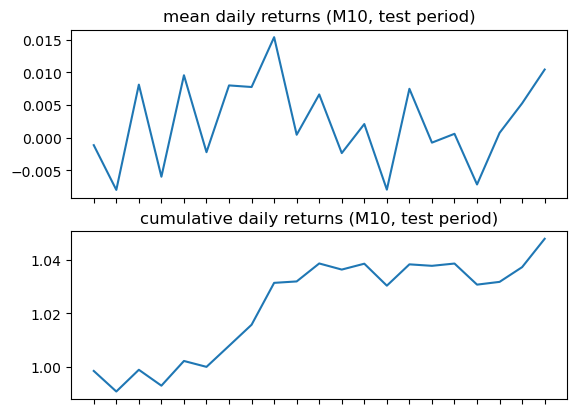

,D05.SI,S58.SI,BS6.SI,U11.SI,Z74.SI,O39.SI,U96.SI,C07.SI,S51.SI,C09.SI,mean
date,,,,,,,,,,,
2022-10-03 00:00:00,1.007188,1.006645,1.009709,1.003440,0.977444,1.000000,NaN,0.984315,NaN,1.000000,0.998592
2022-10-04 00:00:00,1.000200,1.006645,0.989911,1.000361,0.973684,0.985544,0.996753,0.956208,1.000000,1.000000,0.990931
2022-10-05 00:00:00,0.999001,1.020111,0.989911,0.986972,0.996068,0.990501,1.009656,0.952145,1.045872,1.000000,0.999024
2022-10-06 00:00:00,0.993919,1.006279,0.932800,0.992931,1.007786,0.986370,1.003036,0.956711,1.055046,0.996159,0.993104
2022-10-07 00:00:00,0.990369,1.016376,1.000640,0.994421,1.003787,0.985544,1.003036,0.952914,1.073395,1.002561,1.002304
2022-10-10 00:00:00,0.998654,1.006075,0.975200,0.980640,1.019657,0.985544,1.003036,0.961254,1.082569,0.988476,1.000111
2022-10-11 00:00:00,0.995043,1.026263,1.007438,0.981013,1.015562,0.984706,1.019319,0.994382,1.082569,0.973111,1.007941
2022-10-12 00:00:00,0.990562,1.054284,0.998828,0.978404,1.023687,0.990563,1.036139,1.029875,1.082569,0.973111,1.015802
2022-10-13 00:00:00,1.015134,1.098675,1.024222,0.987302,1.023687,0.999876,1.053524,1.036806,1.082569,0.992242,1.031404


In [35]:
# Visualize returns for test period

import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(return_oct_summary['mean'])
ax1.title.set_text('mean daily returns (M10, test period)')

ax2 = fig.add_subplot(2,1,2, sharex=ax1)
ax2.plot(cumreturn_oct_summary['mean'])
ax2.title.set_text('cumulative daily returns (M10, test period)')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

plt.show()

# display cumulative returns
cumreturn_oct_summary

### 5.2 Computing annual volativity and sharpe ratio


In [36]:
def std_dev(data):
    # Get number of observations
    n = len(data)
    # Calculate mean
    mean = sum(data) / n
    # Calculate deviations from the mean
    deviations = sum([(x - mean)**2 for x in data])
    # Calculate Variance & Standard Deviation
    variance = deviations / (n - 1)
    s = variance**(1/2)
    
    return s

# annual volatility

def annual_vola(data):
    s = std_dev(data)
    annual_volatility = 252**(1/2) * s
    
    return annual_volatility

# Sharpe Ratio From Scratch
def sharpe_ratio(data, 
                 risk_free_rate=((1.03465)**(1/365)-1)): # 3.5% risk-free rate based on singapore's tbills
                    
    # Calculate Average Daily Return
    mean_daily_return = sum(data) / len(data)
    # Calculate Standard Deviation
    s = std_dev(data)
    # Calculate Daily Sharpe Ratio
    daily_sharpe_ratio = (mean_daily_return - risk_free_rate) / s
    # Annualize Daily Sharpe Ratio
    sharpe_ratio = 252**(1/2) * daily_sharpe_ratio
    
    return sharpe_ratio

In [37]:
# annual vola for train (2022M1-M7), validation (2022M8-M9), and test period (2022M10)

print("annual vola")
print("train period (2022M1-M7) = {}".format(annual_vola(return_summary['mean'])))
print("validation period (2022M8-M9) = {}".format(annual_vola(return_eval_summary['mean'])))
print("test period (2022M10) = {}".format(annual_vola(return_oct_summary['mean'])))
print()

print("sharpe ratio")
print("train period (2022M1-M7) = {}".format(sharpe_ratio(return_summary['mean'])))
print("validation period (2022M8-M9) = {}".format(sharpe_ratio(return_eval_summary['mean'])))
print("test period (2022M10) = {}".format(sharpe_ratio(return_oct_summary['mean'])))

annual vola
train period (2022M1-M7) = 0.09104763218373926
validation period (2022M8-M9) = 0.09879472358774025
test period (2022M10) = 0.10536729880701697

sharpe ratio
train period (2022M1-M7) = 1.5880859746979745
validation period (2022M8-M9) = 5.140148642036976
test period (2022M10) = 5.388384017065282
[CV] END bootstrap=False, max_depth=930, max_features=sqrt, min_samples_leaf=16, min_samples_split=2, n_estimators=1800; total time=  15.0s
[CV] END bootstrap=True, max_depth=800, max_features=None, min_samples_leaf=16, min_samples_split=10, n_estimators=1400; total time=  13.6s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=400; total time=   3.0s
[CV] END bootstrap=True, max_depth=370, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=  19.0s
[CV] END bootstrap=True, max_depth=860, max_features=sqrt, min_samples_leaf=14, min_samples_split=2, n_estimators=1400; total time=   8.

[CV] END bootstrap=True, max_depth=800, max_features=None, min_samples_leaf=16, min_samples_split=10, n_estimators=1400; total time=  15.7s
[CV] END bootstrap=False, max_depth=770, max_features=log2, min_samples_leaf=16, min_samples_split=5, n_estimators=800; total time=   6.3s
[CV] END bootstrap=False, max_depth=810, max_features=log2, min_samples_leaf=16, min_samples_split=40, n_estimators=800; total time=   5.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=400; total time=   2.9s
[CV] END bootstrap=True, max_depth=370, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=  18.9s
[CV] END bootstrap=True, max_depth=860, max_features=sqrt, min_samples_leaf=14, min_samples_split=2, n_estimators=1400; total time=   8.3s
[CV] END bootstrap=True, max_depth=860, max_features=sqrt, min_samples_leaf=14, min_samples_split=2, n_estimators=1400; total time=   8.4s
[CV] END bootstrap=True, m

[CV] END bootstrap=True, max_depth=800, max_features=None, min_samples_leaf=16, min_samples_split=10, n_estimators=1400; total time=  16.0s
[CV] END bootstrap=False, max_depth=810, max_features=log2, min_samples_leaf=16, min_samples_split=40, n_estimators=800; total time=   5.9s
[CV] END bootstrap=False, max_depth=570, max_features=None, min_samples_leaf=14, min_samples_split=40, n_estimators=400; total time=   5.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=30, n_estimators=400; total time=   2.9s
[CV] END bootstrap=True, max_depth=370, max_features=None, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=  18.7s
[CV] END bootstrap=False, max_depth=180, max_features=None, min_samples_leaf=1, min_samples_split=20, n_estimators=1400; total time=  21.8s
[CV] END bootstrap=False, max_depth=150, max_features=sqrt, min_samples_leaf=7, min_samples_split=20, n_estimators=1000; total time=   7.2s
[CV] END bootstrap=Fals

[CV] END bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=   2.6s
[CV] END bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=   2.4s
[CV] END bootstrap=True, max_depth=150, max_features=sqrt, min_samples_leaf=1, min_samples_split=40, n_estimators=400; total time=   2.3s
[CV] END bootstrap=False, max_depth=550, max_features=sqrt, min_samples_leaf=16, min_samples_split=2, n_estimators=1000; total time=   5.8s
[CV] END bootstrap=False, max_depth=980, max_features=None, min_samples_leaf=20, min_samples_split=5, n_estimators=1600; total time=  18.0s
[CV] END bootstrap=False, max_depth=540, max_features=log2, min_samples_leaf=14, min_samples_split=40, n_estimators=1800; total time=  10.2s
[CV] END bootstrap=True, max_depth=70, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1600; total time=  16.1s
[CV] END bootstrap=True, ma